In [1]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

file_path = r"C:\Users\thais\Documents\00_MACHINE_LEARNING\PROVA TECNICA DATA SCIENCE\LOCALES.csv" 
data = pd.read_csv(file_path, low_memory=False)

In [5]:
# 2. Seleccionar y preparar los datos relevantes
df_analysis = data[['Data_Revisio', 'Codi_Districte', 'Nom_Principal_Activitat']].dropna()

# Convertir 'Data_Revisio' a datetime 
df_analysis['Data_Revisio'] = pd.to_datetime(df_analysis['Data_Revisio'], errors='coerce')

# Creo una columna "Activo" donde 1 indica actividad registrada y 0 indica inactividad
df_analysis['Activo'] = df_analysis['Nom_Principal_Activitat'].notna().astype(int)

# Agrupo por fecha y código de distrito, sumando los locales activos
activity_trend_location = df_analysis.groupby(['Data_Revisio', 'Codi_Districte'])['Activo'].sum()

In [10]:
# 3. Preparo los datos para Prophet para el distrito de interés
distrito = 6 # podemos cambiar codigo distrito
df_prophet_district = activity_trend_location.xs(distrito, level='Codi_Districte').reset_index()
df_prophet_district.columns = ['ds', 'y']  # Atención, Prophet requiere que las columnas sean 'ds' (fecha) y 'y' (valor locales activos)

In [7]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y prueba
df_prophet_district = df_prophet_district.sort_values('ds')  # ordenar por fecha
train, test = train_test_split(df_prophet_district, test_size=0.2, shuffle=False)

# 4. Crear y entrenar el modelo Prophet
model = Prophet()
model.fit(train[['ds', 'y']])

15:26:10 - cmdstanpy - INFO - Chain [1] start processing
15:26:10 - cmdstanpy - INFO - Chain [1] done processing


_Indica que el model està entrenat sense errors_

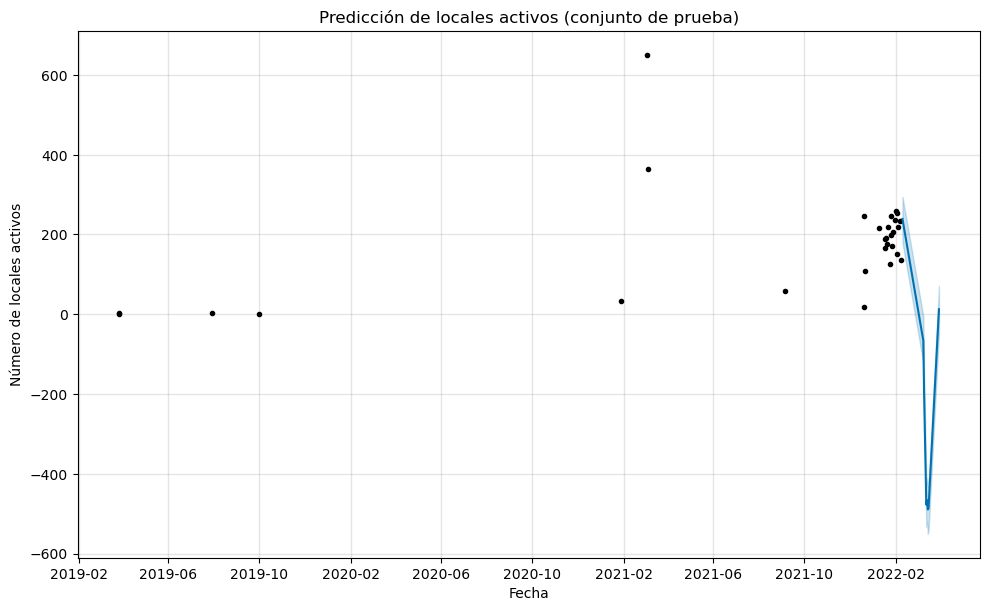

In [15]:
# Usamos directamente el conjunto de prueba 'test' sin añadir más fechas
forecast_test = model.predict(test[['ds']])

# Visualizar las predicciones
model.plot(forecast_test)
plt.title("Predicción de locales activos (conjunto de prueba)")
plt.xlabel("Fecha")
plt.ylabel("Número de locales activos")
plt.show()

In [17]:
# 6. Evaluar el rendimiento del modelo con métricas como MAE y RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np  # Asegúrate de importar numpy

mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 410.89838617231453
RMSE: 469.5388859532311


In [19]:
# 7. Realizar predicciones para el futuro (por ejemplo, los próximos 365 días)
future = model.make_future_dataframe(periods=365)

# 8. Realizar las predicciones
forecast = model.predict(future)

15:36:15 - cmdstanpy - INFO - Chain [1] start processing
15:36:16 - cmdstanpy - INFO - Chain [1] done processing
15:36:16 - cmdstanpy - INFO - Chain [1] start processing
15:36:18 - cmdstanpy - INFO - Chain [1] done processing
15:36:18 - cmdstanpy - INFO - Chain [1] start processing
15:36:23 - cmdstanpy - INFO - Chain [1] done processing
15:36:23 - cmdstanpy - INFO - Chain [1] start processing
15:36:27 - cmdstanpy - INFO - Chain [1] done processing
15:36:27 - cmdstanpy - INFO - Chain [1] start processing
15:36:42 - cmdstanpy - INFO - Chain [1] done processing
15:36:43 - cmdstanpy - INFO - Chain [1] start processing
15:36:44 - cmdstanpy - INFO - Chain [1] done processing
15:36:44 - cmdstanpy - INFO - Chain [1] start processing
15:36:45 - cmdstanpy - INFO - Chain [1] done processing
15:36:45 - cmdstanpy - INFO - Chain [1] start processing
15:36:45 - cmdstanpy - INFO - Chain [1] done processing
15:36:45 - cmdstanpy - INFO - Chain [1] start processing
15:36:47 - cmdstanpy - INFO - Chain [1]

Mejores parámetros: {'changepoint_prior_scale': 1.0, 'changepoint_range': 0.95, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Mejor MAE: 210.179624788142
Mejor RMSE: 214.01880678125497


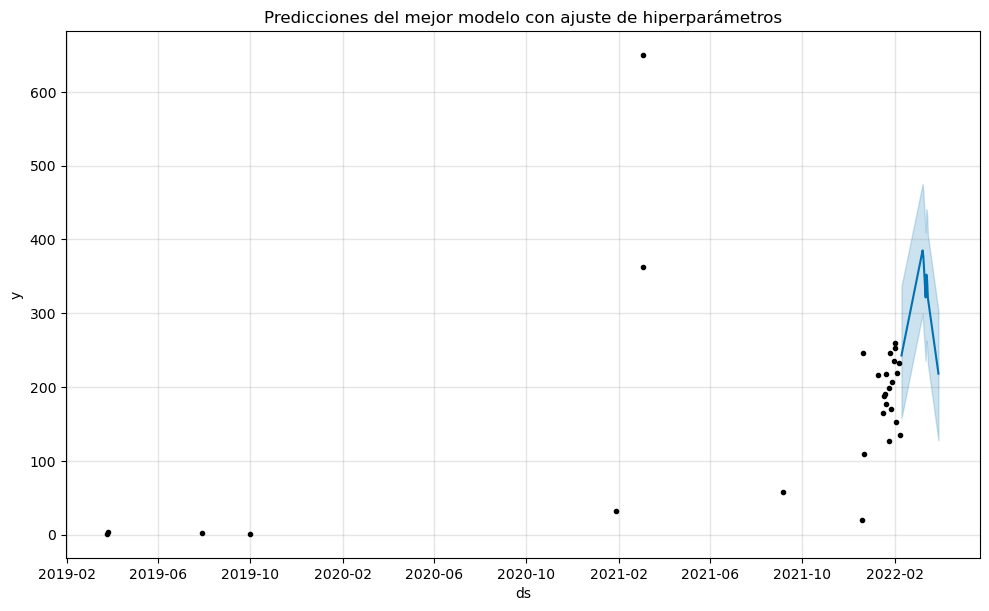

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import numpy as np
from sklearn.model_selection import ParameterGrid

# Definir los valores de los hiperparámetros que queremos probar
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95]
}

# Crear una lista de todas las combinaciones posibles de hiperparámetros
grid = ParameterGrid(param_grid)

# Variables para almacenar los mejores resultados
best_mae = float('inf')
best_rmse = float('inf')
best_params = None
best_model = None

# Búsqueda de los mejores hiperparámetros
for params in grid:
    # Entrenar el modelo con la combinación actual de hiperparámetros
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        changepoint_range=params['changepoint_range']
    )
    
    # Ajustar el modelo al conjunto de entrenamiento
    model.fit(train[['ds', 'y']])
    
    # Realizar predicciones sobre el conjunto de prueba
    forecast_test = model.predict(test[['ds']])
    
    # Calcular las métricas de error
    mae = mean_absolute_error(test['y'], forecast_test['yhat'])
    rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
    
    # Verificar si este modelo tiene mejores métricas
    if mae < best_mae and rmse < best_rmse:
        best_mae = mae
        best_rmse = rmse
        best_params = params
        best_model = model

# Mostrar los mejores hiperparámetros y las métricas de error
print(f"Mejores parámetros: {best_params}")
print(f"Mejor MAE: {best_mae}")
print(f"Mejor RMSE: {best_rmse}")

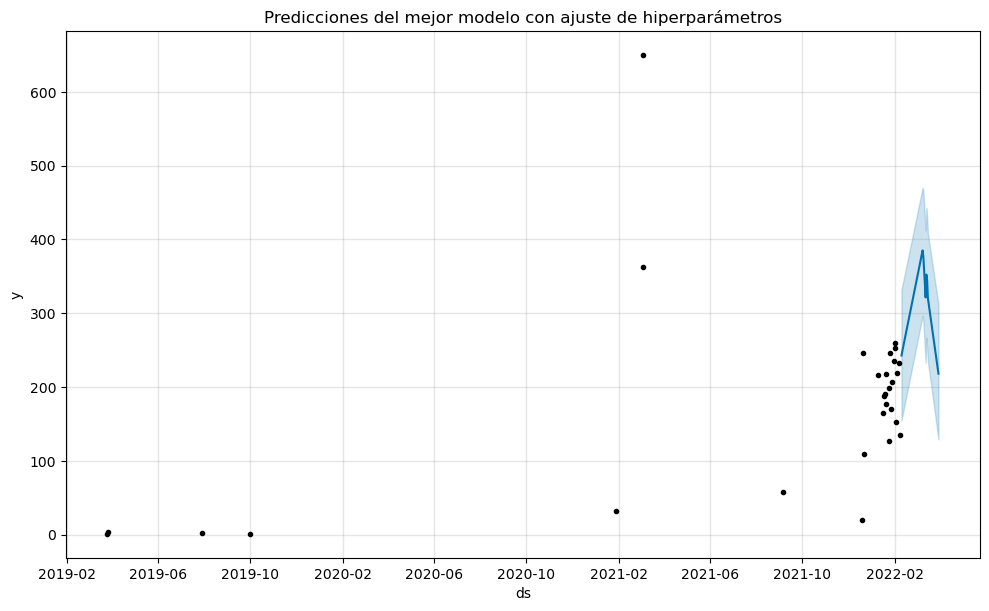

In [21]:
# Realizar predicciones con el mejor modelo
forecast_best = best_model.predict(test[['ds']])

# Graficar las predicciones del mejor modelo
best_model.plot(forecast_best)
plt.title("Predicciones del mejor modelo con ajuste de hiperparámetros")
plt.show()


In [22]:
import joblib

# Guardar el mejor modelo entrenado en un archivo
joblib.dump(best_model, 'prophet_model.pkl')

['prophet_model.pkl']